In [36]:
import os
import uuid
from base64 import b64decode
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage


In [22]:
load_dotenv()

True

In [6]:
# Partition PDF tables,texts and images
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = output_path + "attention.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,
    strategy="hi_res",

    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,   #extracts base64 for API Usgae

    chunking_strategy="by_title",  # all content under a title is extracted as a single chunk 
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
    languages=["eng"]                      
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [7]:
len(chunks)

12

In [8]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [9]:
chunks[3].metadata.orig_elements

In [10]:
# This is what an extracted image looks like.
# It contains the base64 representation only 
elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '56a05eb6-aac4-47a1-9d21-b5231578344b',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(486.0),
     np.float64(261.1805555555558)),
    (np.float64(486.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(261.1805555555558))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-07-22T22:39:40',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJ

In [11]:
# Separate extracted elements into tables, text, and images
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [15]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

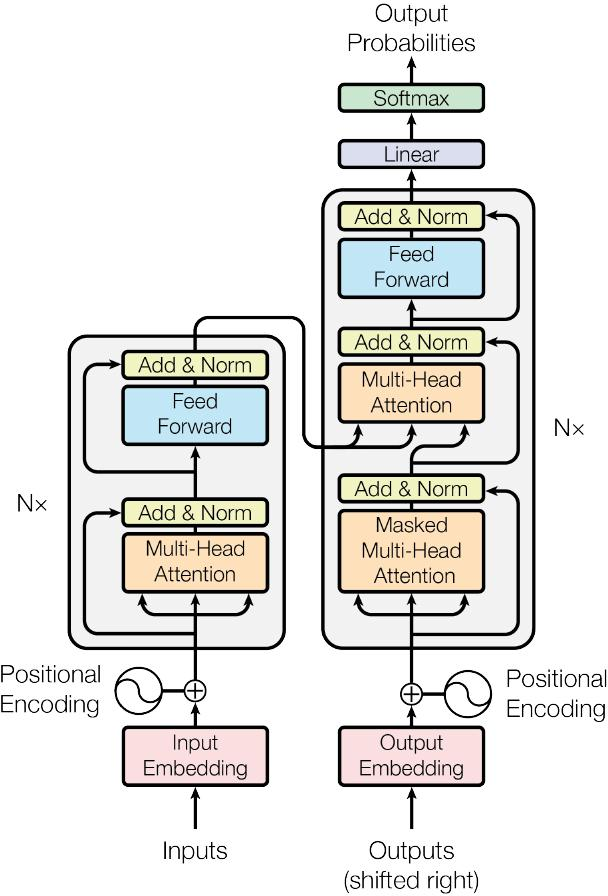

In [16]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [18]:
# Text and table summaries

prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.2,
    groq_api_key=os.getenv("GROQ_API_KEY"),
)

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [19]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [20]:
text_summaries

['Researchers propose the Transformer, a new neural network architecture based solely on attention mechanisms, which achieves state-of-the-art results in machine translation tasks, including English-to-German and English-to-French translation, and generalizes well to other tasks like English constituency parsing.',
 'Recurrent neural networks have been the state of the art in sequence modeling, but their sequential nature limits parallelization. Recent models have tried to address this with factorization and conditional computation, but the fundamental constraint remains. The proposed Transformer model relies entirely on an attention mechanism to draw global dependencies, allowing for more parallelization and achieving state-of-the-art results in translation quality. It differs from other models like ConvS2S and ByteNet, which use convolutional neural networks, and is the first transduction model to rely entirely on self-attention without using sequence-aligned RNNs or convolution.',
 

In [23]:
# Image summaries

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""

messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

llm = ChatGroq(
    model_name="meta-llama/llama-4-maverick-17b-128e-instruct",
    api_key=os.environ.get("GROQ_API_KEY1"),  
)

chain = prompt | llm | StrOutputParser()

image_summaries = chain.batch(images)

In [24]:
image_summaries

['The image is a diagram of the Transformer architecture, a type of neural network used for natural language processing tasks. The diagram is divided into two main sections: the encoder and the decoder.\n\n**Encoder:**\n\n* The encoder takes in a sequence of input tokens (e.g., words or characters) and outputs a sequence of vectors.\n* The input tokens are first embedded into a high-dimensional space using an embedding layer.\n* The embedded inputs are then passed through a series of identical layers, each consisting of two sub-layers:\n\t+ Multi-Head Attention: This sub-layer applies self-attention to the input sequence, allowing the model to attend to different parts of the input sequence simultaneously.\n\t+ Feed Forward Network (FFN): This sub-layer applies a fully connected feed-forward network to the output of the multi-head attention sub-layer.\n* The output of the final encoder layer is passed through a linear layer and a softmax layer to produce the output probabilities.\n\n**

In [25]:
print(image_summaries[1])

The image is a flowchart that illustrates the process of self-attention in the Transformer architecture, a type of neural network used primarily for natural language processing tasks.

**Key Components:**

* The flowchart consists of five rectangular boxes, each representing a different operation, arranged vertically.
* The boxes are labeled as follows:
	+ MatMul (twice)
	+ SoftMax
	+ Mask (opt.)
	+ Scale
* Arrows connect the boxes, indicating the direction of data flow between operations.
* The input variables are labeled as Q, K, and V at the bottom of the chart.

**Flowchart Structure:**

* The flowchart begins with two input variables, Q and K, which are fed into the first MatMul operation.
* The output of the first MatMul operation is then passed through the Scale operation.
* The result is then optionally masked using the Mask (opt.) operation.
* The output of the masking operation is then passed through the SoftMax operation.
* The output of the SoftMax operation is then fed int

In [30]:
# Create the VectorStore

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

vectorstore = Chroma(
    collection_name="multi_modal_rag",
    embedding_function=embedding_model,  
    persist_directory="./chroma_db"  
)

store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [33]:
# Load the summaries and link the to the original data

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add table summaries
if tables:
    table_ids = [str(uuid.uuid4()) for _ in tables]
    summary_tables = [
        Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
    ]
    retriever.vectorstore.add_documents(summary_tables)
    retriever.docstore.mset(list(zip(table_ids, tables)))


# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))


In [34]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [35]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

[36] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna. Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.

[37] Vinyals & Kaiser, Koo, Petrov, Sutskever, and Hinton. Grammar as a foreign language. In Advances in Neural Information Processing Systems, 2015.

[38] Yonghui Wu, Mike Schuster, Zhifeng Chen, Quoc V Le, Mohammad Norouzi, Wolfgang Macherey, Maxim Krikun, Yuan Cao, Qin Gao, Klaus Macherey, et al. Google’s neural machine translation system: Bridging the gap between human and machine translation. arXiv preprint arXiv:1609.08144, 2016.

[39] Jie Zhou, Ying Cao, Xuguang Wang, Peng Li, and Wei Xu. Deep recurrent models with fast-forward connections for neural machine translation. CoRR, abs/1606.04199, 2016.

[40] Muhua Zhu, Yue Zhang, Wenliang Chen, Min Zhang, and Jingbo Zhu. Fast and accurate shift-reduce constituent parsing. In Proceedings of the 51st Annual Meeting of the ACL (Volume 1: Long Papers), pages

In [37]:
def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}

In [38]:
def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


In [50]:
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatGroq(
        model_name="meta-llama/llama-4-maverick-17b-128e-instruct",
        api_key=os.environ.get("GROQ_API_KEY")
    )
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatGroq(
        model_name="meta-llama/llama-4-maverick-17b-128e-instruct",
        api_key=os.environ.get("GROQ_API_KEY1")
    )
        | StrOutputParser()
    )
)

In [51]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism is a component of neural networks that enables the model to focus on specific parts of the input data when making predictions or decisions. In the context of the provided image, the attention mechanism is visualized as a series of lines connecting words in a sentence, indicating the relationships between them.

**Key Features of the Attention Mechanism:**

*   **Selective Focus:** The attention mechanism allows the model to selectively concentrate on certain aspects of the input data, such as specific words or phrases in a sentence.
*   **Weighted Connections:** The lines in the image represent weighted connections between words, with thicker lines indicating stronger relationships.
*   **Contextual Understanding:** The attention mechanism helps the model to understand the context of the input data, enabling it to capture long-distance dependencies and complex relationships.

**How the Attention Mechanism Works:**

1.  **Input Processing:** The input data, such 

Response: MultiHead(Q,K,V ) = Concat(head1,...,headh)W O where headi = Attention(QW Q i ,KW K i ,V W V i ). Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. It linearly projects the queries, keys, and values h times with different learned linear projections to dk, dk, and dv dimensions, performs the attention function in parallel, and then concatenates and projects the output values. In this work, h = 8 parallel attention layers or heads are employed.


Context:
3.2.2 Multi-Head Attention

Instead of performing a single attention function with dmodel-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional

‘To illustra

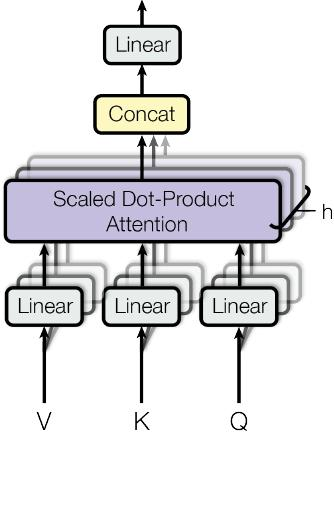

In [42]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)